In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np
import seaborn as sns
import os

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_selection import RFECV, SelectFromModel, SelectKBest
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

from keras.optimizers import RMSprop, SGD, Adam
from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential
%matplotlib inline

In [4]:
nvda = pd.read_csv(r'C:\Users\Aaditya Saini\Desktop\stock_price_prediction_model\predicition_pipeline\NVDA.csv')
features_selected = ['Date','Close(t)']
nvda = nvda[features_selected]
nvda = nvda.iloc[3500:-60, :]
nvda = nvda.rename(columns={'Close(t)':'Close'})
nvda = nvda.set_index('Date')
nvda.tail()

,Close
Date,
2025-10-20 00:00:00-04:00,182.629837
2025-10-21 00:00:00-04:00,181.149918
2025-10-22 00:00:00-04:00,180.269958
2025-10-23 00:00:00-04:00,182.149857
2025-10-24 00:00:00-04:00,186.249619


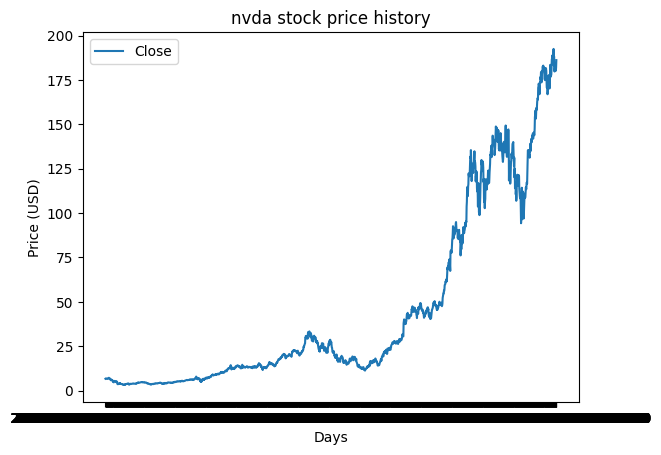

In [5]:
plt.figure()
plt.plot(nvda["Close"])
plt.title('nvda stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Close'], loc='upper left')
plt.show()

In [6]:
gs = pd.read_csv(r'C:\Users\Aaditya Saini\Desktop\stock_price_prediction_model\predicition_pipeline\GS.csv')
#best features
features_selected = ['Date','Close(t)']
gs = gs[features_selected]
gs = gs.iloc[3500:-60, :]
gs = gs.rename(columns={'Close(t)':'Close'})
gs = gs.set_index('Date')


jnj = pd.read_csv(r'C:\Users\Aaditya Saini\Desktop\stock_price_prediction_model\predicition_pipeline\JNJ.csv')
#best features
features_selected = ['Date','Close(t)']
jnj = jnj[features_selected]
jnj = jnj.iloc[3500:-60, :]
jnj = jnj.rename(columns={'Close(t)':'Close'})
jnj = jnj.set_index('Date')


ibm = pd.read_csv(r'C:\Users\Aaditya Saini\Desktop\stock_price_prediction_model\predicition_pipeline\IBM.csv')
#best features
features_selected = ['Date','Close(t)']
ibm = ibm[features_selected]
ibm = ibm.iloc[3500:-60, :]
ibm = ibm.rename(columns={'Close(t)':'Close'})
ibm = ibm.set_index('Date')

In [7]:
for stock_df in (nvda, ibm, jnj, gs):
    stock_df['Normed Return']=stock_df['Close']/stock_df['Close'][0]

C:\Users\Aaditya Saini\AppData\Local\Temp\ipykernel_26748\2698145198.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stock_df['Normed Return']=stock_df['Close']/stock_df['Close'][0]
C:\Users\Aaditya Saini\AppData\Local\Temp\ipykernel_26748\2698145198.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stock_df['Normed Return']=stock_df['Close']/stock_df['Close'][0]
C:\Users\Aaditya Saini\AppData\Local\Temp\ipykernel_26748\2698145198.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavio

In [9]:
for stock_df, weight in zip((nvda, ibm, jnj, gs), [0.3, 0.1, 0.3, 0.3]):
    stock_df['Allocation'] = stock_df['Normed Return'] * weight

In [10]:
nvda.head()

,Close,Normed Return,Allocation
Date,,,
2018-09-12 00:00:00-04:00,6.642567,1.000000,0.300000
2018-09-13 00:00:00-04:00,6.720339,1.011708,0.303512
2018-09-14 00:00:00-04:00,6.846402,1.030686,0.309206
2018-09-17 00:00:00-04:00,6.784485,1.021365,0.306409
2018-09-18 00:00:00-04:00,6.712412,1.010515,0.303154


In [13]:
for stock_df in (nvda,ibm,jnj,gs):
    stock_df['Position Value'] = stock_df['Allocation'].cumsum()

In [14]:
all_pos_vals = [nvda['Position Value'], ibm['Position Value'], jnj['Position Value'], gs['Position Value']]
portfolio_val = pd.concat(all_pos_vals, axis=1)
portfolio_val.columns = ['nvda', 'ibm', 'JNJ', 'GS']
portfolio_val['Total'] = portfolio_val.sum(axis=1)

In [15]:
portfolio_val.head(18)

,nvda,ibm,JNJ,GS,Total
Date,,,,,
2018-09-12 00:00:00-04:00,0.300000,0.100000,0.300000,0.300000,1.000000
2018-09-13 00:00:00-04:00,0.603512,0.201624,0.601141,0.600237,2.006514
2018-09-14 00:00:00-04:00,0.912718,0.302825,0.901421,0.901670,3.018634
2018-09-17 00:00:00-04:00,1.219128,0.403759,1.202712,1.201328,4.026927
2018-09-18 00:00:00-04:00,1.522282,0.505117,1.505253,1.502301,5.034953
2018-09-19 00:00:00-04:00,1.826510,0.606816,1.807621,1.812071,6.053018
2018-09-20 00:00:00-04:00,2.124363,0.709941,2.113261,2.124234,7.071798
2018-09-21 00:00:00-04:00,2.419050,0.813202,2.420838,2.433688,8.086778
2018-09-24 00:00:00-04:00,2.716253,0.915562,2.723228,2.739934,9.094977


<Axes: title={'center': 'Total Portfolio Value'}, xlabel='Date'>

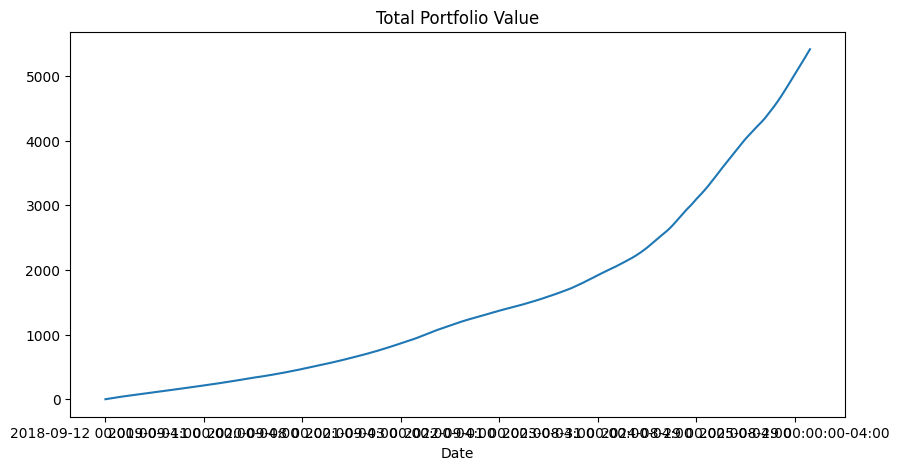

In [16]:
portfolio_val['Total'].plot(figsize=(10,5), title='Total Portfolio Value')  

<Axes: title={'center': 'Individual Stock Position Value'}, xlabel='Date'>

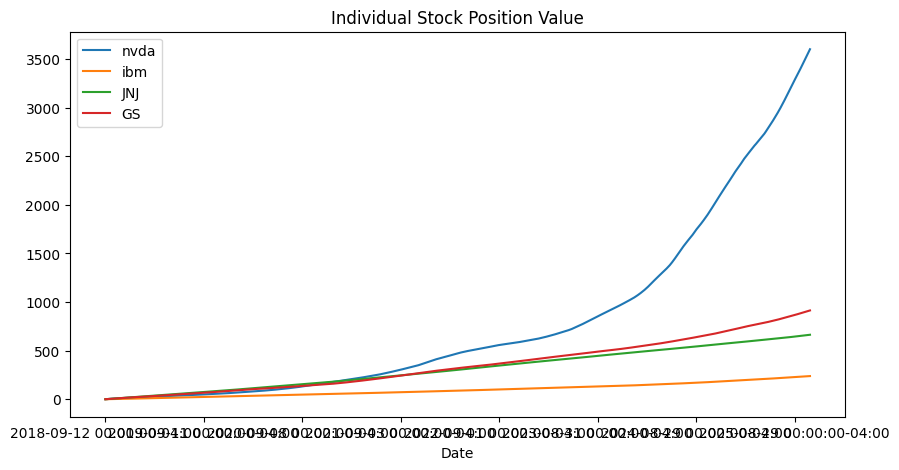

In [17]:
portfolio_val.drop('Total',axis=1).plot(figsize=(10,5), title='Individual Stock Position Value')

In [18]:
portfolio_val['Daily Return'] = portfolio_val['Total'].pct_change(1)

<Axes: ylabel='Frequency'>

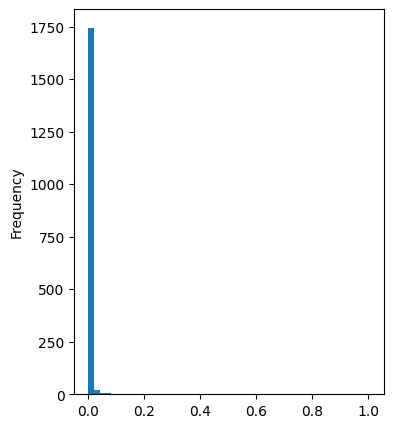

In [19]:
portfolio_val['Daily Return'].mean()
portfolio_val['Daily Return'].std()
portfolio_val['Daily Return'].plot(kind='hist', bins=50, figsize=(4,5))

In [20]:
cum_return = 100 * (portfolio_val['Total'][-1] / portfolio_val['Total'][0] - 1)
cum_return

C:\Users\Aaditya Saini\AppData\Local\Temp\ipykernel_26748\3820785891.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cum_return = 100 * (portfolio_val['Total'][-1] / portfolio_val['Total'][0] - 1)


541364.9441986574

In [21]:
sharpe_ratio = portfolio_val['Daily Return'].mean() / portfolio_val['Daily Return'].std()
ASR = (252**0.5) * sharpe_ratio
ASR

2.710624954347733

In [22]:
stocks = pd.concat([nvda.Close, ibm.Close, gs.Close, jnj.Close], axis=1)
stocks.columns = ['nvda', 'ibm', 'GS', 'JNJ']
stocks

,nvda,ibm,GS,JNJ
Date,,,,
2018-09-12 00:00:00-04:00,6.642567,101.995209,193.054657,113.755692
2018-09-13 00:00:00-04:00,6.720339,103.651405,193.206970,114.188309
2018-09-14 00:00:00-04:00,6.846402,103.219940,193.976959,113.861824
2018-09-17 00:00:00-04:00,6.784485,102.948547,192.834625,114.245461
2018-09-18 00:00:00-04:00,6.712412,103.380020,193.680832,114.718880
...,...,...,...,...
2025-10-20 00:00:00-04:00,182.629837,282.094635,759.554504,192.497787
2025-10-21 00:00:00-04:00,181.149918,280.503387,755.235901,190.669403
2025-10-22 00:00:00-04:00,180.269958,285.933472,740.926819,191.722717


In [23]:
stocks.pct_change(1).mean()

nvda    0.002417
ibm     0.000756
GS      0.000982
JNJ     0.000361
dtype: float64

In [24]:
stocks.pct_change(1).head()

,nvda,ibm,GS,JNJ
Date,,,,
2018-09-12 00:00:00-04:00,NaN,NaN,NaN,NaN
2018-09-13 00:00:00-04:00,0.011708,0.016238,0.000789,0.003803
2018-09-14 00:00:00-04:00,0.018758,-0.004163,0.003985,-0.002859
2018-09-17 00:00:00-04:00,-0.009044,-0.002629,-0.005889,0.003369
2018-09-18 00:00:00-04:00,-0.010623,0.004191,0.004388,0.004144


In [25]:
log_return = np.log(stocks / stocks.shift(1))
log_return.head()

,nvda,ibm,GS,JNJ
Date,,,,
2018-09-12 00:00:00-04:00,NaN,NaN,NaN,NaN
2018-09-13 00:00:00-04:00,0.011640,0.016108,0.000789,0.003796
2018-09-14 00:00:00-04:00,0.018585,-0.004171,0.003977,-0.002863
2018-09-17 00:00:00-04:00,-0.009085,-0.002633,-0.005906,0.003364
2018-09-18 00:00:00-04:00,-0.010680,0.004182,0.004379,0.004135


In [26]:
weights = np.array(np.random.random(4))
print('Random Weights:')
print(weights)

print('Rebalance')
weights = weights / np.sum(weights)
print(weights)

Random Weights:
[0.72023186 0.86073491 0.69605519 0.44295098]
Rebalance
[0.26479376 0.31644981 0.25590519 0.16285124]


In [27]:
exp_ret = np.sum((log_return.mean() * weights) * 252)

# Expected volatility
exp_vol = np.sqrt(np.dot(weights.T, np.dot(log_return.cov() * 252, weights)))

# Sharpe Ratio
SR = exp_ret / exp_vol

In [28]:
num_ports = 8000
all_weights = np.zeros((num_ports, len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports): 
    weights = np.array(np.random.random(4)) 
    weights = weights / np.sum(weights)  
    all_weights[ind,:] = weights
    ret_arr[ind] = np.sum((log_return.mean() * weights) * 252)
    vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(log_return.cov() * 252, weights)))
    sharpe_arr[ind] = ret_arr[ind] / vol_arr[ind]

In [29]:
sharpe_arr.max()

0.9642324714121467

In [31]:
sharpe_arr.argmax()

3048

In [32]:
all_weights[3048, :]

array([0.40554791, 0.23553146, 0.12014652, 0.23877411])

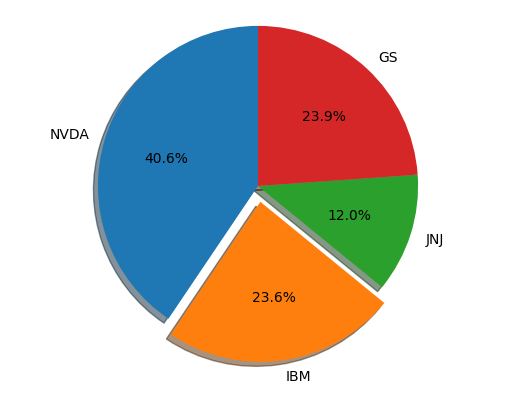

In [34]:
labels = 'NVDA', 'IBM', 'JNJ', 'GS'
best_weights = all_weights[sharpe_arr.argmax(), :]
sizes = best_weights * 100
explode = (0, 0.1, 0, 0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

In [35]:
sizes=[40.5,23.5,12,23.8]

In [36]:
from scipy.optimize import minimize

def get_ret_vol_sr(weights): 
    weights = np.array(weights)
    ret = np.sum(log_return.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_return.cov() * 252, weights)))
    sr = ret / vol 
    return np.array([ret, vol, sr])

def neg_sharpe(weights): 
    return get_ret_vol_sr(weights)[2] * -1

def check_sum(weights): 
    return np.sum(weights) - 1

In [37]:
cons = ({'type': 'eq', 'fun': check_sum})

In [38]:
bounds = ((0,1), (0,1), (0,1), (0,1))

In [39]:
t_guess = [0.25, 0.25, 0.25, 0.25]

In [41]:
opt_results = minimize(neg_sharpe, t_guess, method='SLSQP', bounds=bounds, constraints=cons)

In [44]:
opt_results.x

array([0.41138902, 0.23206555, 0.12306537, 0.23348006])

In [45]:
get_ret_vol_sr(opt_results.x)

array([0.27000401, 0.28000944, 0.96426751])